In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm, metrics
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.ensemble as ske
import statsmodels.api as sm
import pylab
import scipy.stats as stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import uniform as sp_rand
from datetime import datetime

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

train.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)
test.rename(columns={'3SsnPorch':'TSsnPorch'}, inplace=True)

## Visualization

In [20]:
# Create a function that shows the basic information of the data
def df_info(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    # needed to transpose uniques
    uniques = df.apply(lambda x: [x.unique()]).T
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ratio = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ratio, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ratio, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ratio', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    
    return str

In [21]:
details = df_info(train, 'SalePrice')
details.sort_values(by = 'corr SalePrice', ascending = False)
details.index
# Check the correlation of the features to SalePrice

Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________


Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [22]:
# Distinguish which features are qualitative and quantitative

numeric = ['int64', 'float64']
not_numeric = ['object']
quantitative = []
qualitative = []
for i in train.columns:
    if train[i].dtype in numeric:
        quantitative.append(train[i].name)
    elif train[i].dtype in not_numeric:
        qualitative.append(train[i].name)


In [23]:
quantitative, qualitative

(['MSSubClass',
  'LotFrontage',
  'LotArea',
  'OverallQual',
  'OverallCond',
  'YearBuilt',
  'YearRemodAdd',
  'MasVnrArea',
  'BsmtFinSF1',
  'BsmtFinSF2',
  'BsmtUnfSF',
  'TotalBsmtSF',
  '1stFlrSF',
  '2ndFlrSF',
  'LowQualFinSF',
  'GrLivArea',
  'BsmtFullBath',
  'BsmtHalfBath',
  'FullBath',
  'HalfBath',
  'BedroomAbvGr',
  'KitchenAbvGr',
  'TotRmsAbvGrd',
  'Fireplaces',
  'GarageYrBlt',
  'GarageCars',
  'GarageArea',
  'WoodDeckSF',
  'OpenPorchSF',
  'EnclosedPorch',
  'TSsnPorch',
  'ScreenPorch',
  'PoolArea',
  'MiscVal',
  'MoSold',
  'YrSold',
  'SalePrice'],
 ['MSZoning',
  'Street',
  'Alley',
  'LotShape',
  'LandContour',
  'Utilities',
  'LotConfig',
  'LandSlope',
  'Neighborhood',
  'Condition1',
  'Condition2',
  'BldgType',
  'HouseStyle',
  'RoofStyle',
  'RoofMatl',
  'Exterior1st',
  'Exterior2nd',
  'MasVnrType',
  'ExterQual',
  'ExterCond',
  'Foundation',
  'BsmtQual',
  'BsmtCond',
  'BsmtExposure',
  'BsmtFinType1',
  'BsmtFinType2',
  'Heating',

Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________
Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________


<AxesSubplot:>

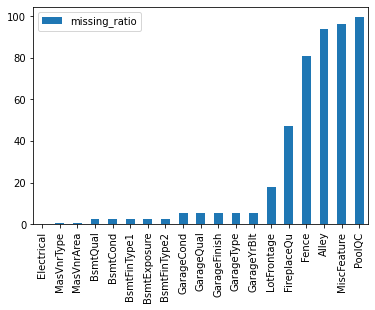

In [24]:
df_have_null = rstr(train)[rstr(train).loc[:]['missing_ratio']>0]
df_have_null = df_have_null.sort_values(by = 'missing_ratio')
df_have_null.plot(y='missing_ratio', kind = 'bar')

# There are 5 features that have more than 47% of missing values
# eliminate these or use them in feature engineering


In [25]:
df_have_null.sort_values(by='nulls')

,types,counts,distincts,nulls,missing_ratio,uniques,skewness,kurtosis
Electrical,object,1459,6,1,0.068493,"[SBrkr, FuseF, FuseA, FuseP, Mix, nan]",NaN,NaN
MasVnrType,object,1452,5,8,0.547945,"[BrkFace, None, Stone, BrkCmn, nan]",NaN,NaN
MasVnrArea,float64,1452,328,8,0.547945,"[196.0, 0.0, 162.0, 350.0, 186.0, 240.0, 286.0...",2.669084,10.082417
BsmtQual,object,1423,5,37,2.534247,"[Gd, TA, Ex, nan, Fa]",NaN,NaN
BsmtCond,object,1423,5,37,2.534247,"[TA, Gd, nan, Fa, Po]",NaN,NaN
BsmtFinType1,object,1423,7,37,2.534247,"[GLQ, ALQ, Unf, Rec, BLQ, nan, LwQ]",NaN,NaN
BsmtExposure,object,1422,5,38,2.602740,"[No, Gd, Mn, Av, nan]",NaN,NaN
BsmtFinType2,object,1422,7,38,2.602740,"[Unf, BLQ, nan, ALQ, Rec, LwQ, GLQ]",NaN,NaN
GarageYrBlt,float64,1379,98,81,5.547945,"[2003.0, 1976.0, 2001.0, 1998.0, 2000.0, 1993....",-0.649415,-0.418341
GarageType,object,1379,7,81,5.547945,"[Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...",NaN,NaN


In [26]:
# Top 10 high correlation
corr_to_price = df_info(train, 'SalePrice')
corr_to_price = corr_to_price.sort_values(by = 'corr SalePrice', ascending = False)
corr_to_price.head(10)

Data shape: (1460, 80)
___________________________
Data types:
 object     43
int64      34
float64     3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ratio,uniques,skewness,kurtosis,corr SalePrice
SalePrice,int64,1460,663,0,0.0,"[208500, 181500, 223500, 140000, 250000, 14300...",1.882876,6.536282,1.000000
OverallQual,int64,1460,10,0,0.0,"[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]",0.216944,0.096293,0.790982
GrLivArea,int64,1460,861,0,0.0,"[1710, 1262, 1786, 1717, 2198, 1362, 1694, 209...",1.366560,4.895121,0.708624
GarageCars,int64,1460,5,0,0.0,"[2, 3, 1, 0, 4]",-0.342549,0.220998,0.640409
GarageArea,int64,1460,441,0,0.0,"[548, 460, 608, 642, 836, 480, 636, 484, 468, ...",0.179981,0.917067,0.623431
TotalBsmtSF,int64,1460,721,0,0.0,"[856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...",1.524255,13.250483,0.613581
1stFlrSF,int64,1460,753,0,0.0,"[856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...",1.376757,5.745841,0.605852
FullBath,int64,1460,4,0,0.0,"[2, 1, 3, 0]",0.036562,-0.857043,0.560664
TotRmsAbvGrd,int64,1460,12,0,0.0,"[8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]",0.676341,0.880762,0.533723
YearBuilt,int64,1460,112,0,0.0,"[2003, 1976, 2001, 1915, 2000, 1993, 2004, 197...",-0.613461,-0.439552,0.522897


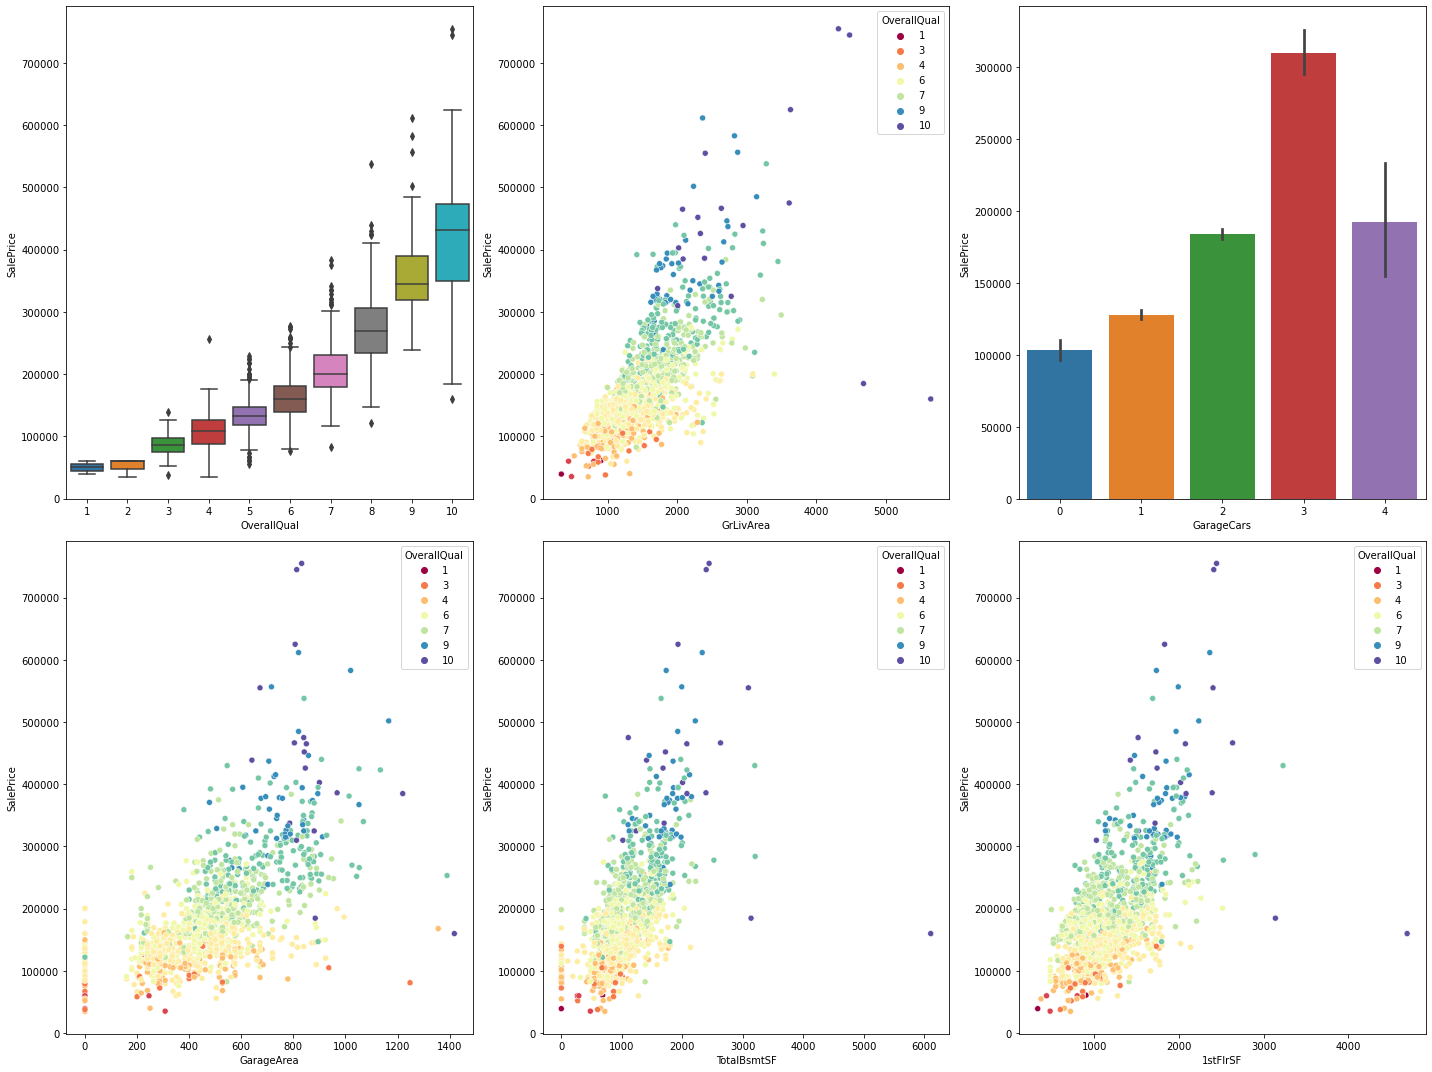

In [27]:
# Plot the correlations to SalePrice

fig = plt.figure(figsize=(20,15))

fig1 = fig.add_subplot(231); sns.boxplot(x='OverallQual', y='SalePrice', data = train[['OverallQual','SalePrice']])
fig2 = fig.add_subplot(232); sns.scatterplot(x='GrLivArea', y='SalePrice', data = train[['GrLivArea','SalePrice', 'OverallQual']], hue='OverallQual' ,palette = 'Spectral')
fig3 = fig.add_subplot(233); sns.barplot(x='GarageCars', y='SalePrice', data = train[['GarageCars','SalePrice']])
fig4 = fig.add_subplot(234); sns.scatterplot(x='GarageArea', y='SalePrice', data = train[['GarageArea','SalePrice', 'OverallQual']], hue='OverallQual' ,palette = 'Spectral')
fig5 = fig.add_subplot(235); sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train[['TotalBsmtSF', 'SalePrice','OverallQual']], hue='OverallQual' ,palette = 'Spectral')
fig6 = fig.add_subplot(236); sns.scatterplot(x='1stFlrSF', y='SalePrice', data=train[['1stFlrSF','SalePrice','OverallQual']], hue='OverallQual' ,palette = 'Spectral')

plt.tight_layout()

In [11]:
##### Check normality of SalePrice #####

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

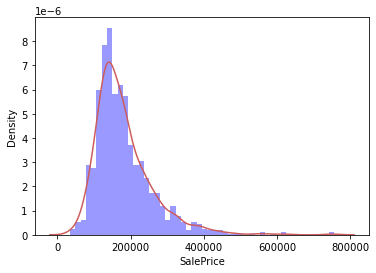

In [28]:
sns.distplot(train['SalePrice'], bins = 50, hist_kws = {'color':'blue', 'label':'histogram'}, kde_kws = {'color':'indianred', 'label':'KDE plot'})

((array([-3.30513952, -3.04793228, -2.90489705, ...,  2.90489705,
          3.04793228,  3.30513952]),
  array([ 34900,  35311,  37900, ..., 625000, 745000, 755000], dtype=int64)),
 (74160.16474519415, 180921.19589041095, 0.9319665641512986))

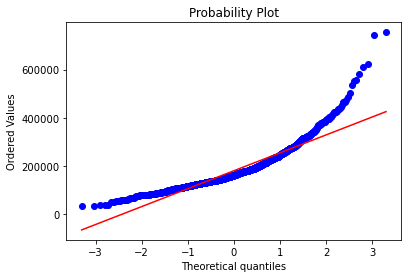

In [29]:
# normal qqplot
stats.probplot(train['SalePrice'], dist="norm", plot=pylab)


In [ ]:
##### not normal, perform transformations #####

Text(0.5, 1.0, 'distribution of Sale Price - inverse transformation')

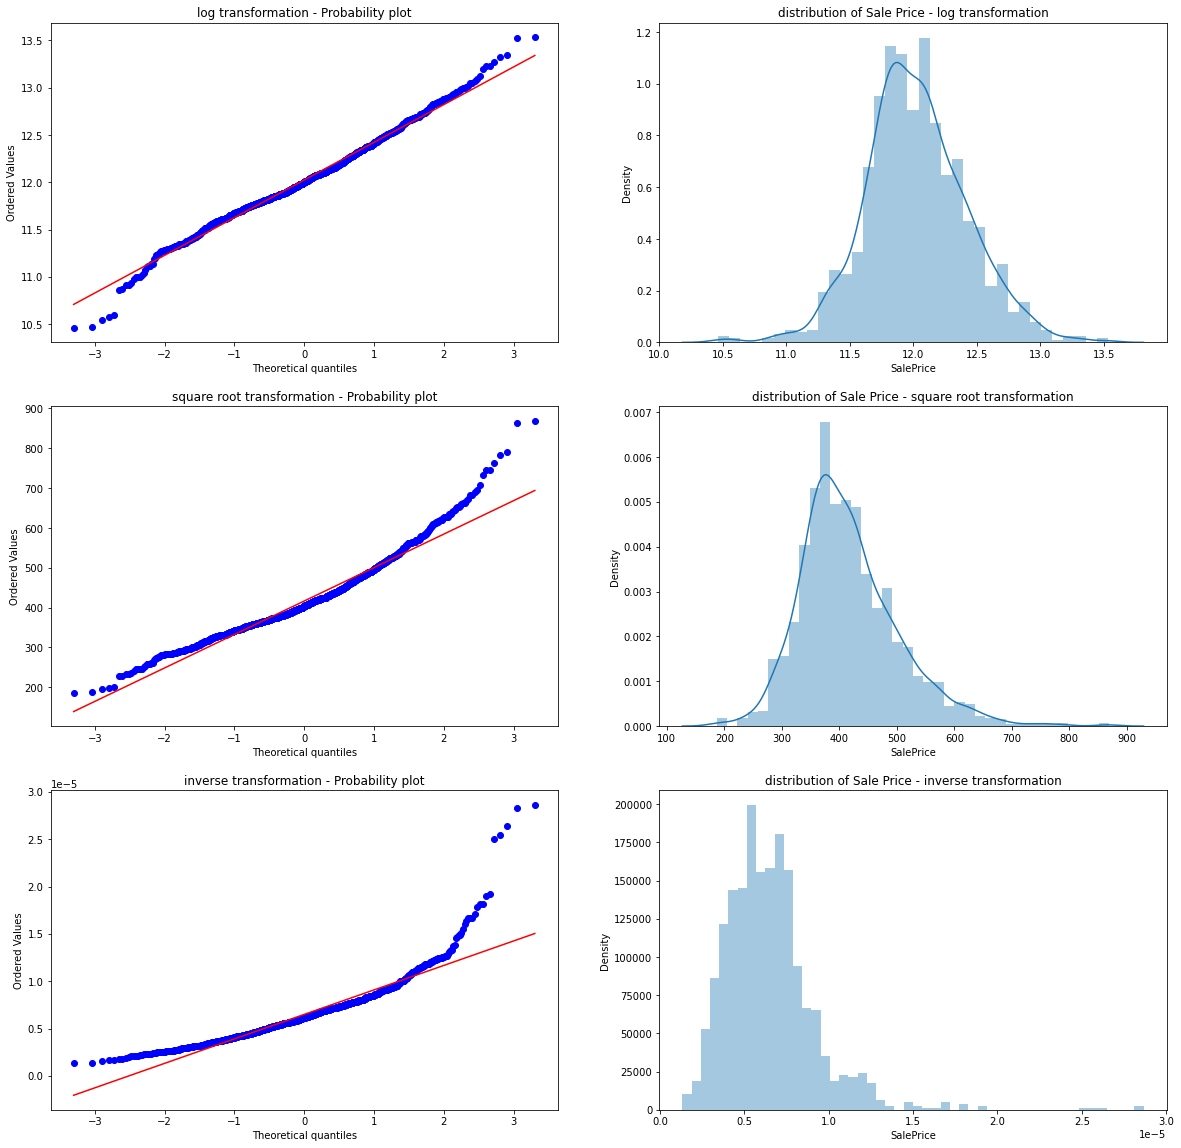

In [30]:
fig=plt.figure(figsize=(20,20))

# log transformation
log_trans = np.log1p(train['SalePrice'])
fig1 = fig.add_subplot(321) ; stats.probplot(log_trans, dist = 'norm', plot = pylab)
fig1.set_title('log transformation - Probability plot')
fig2 = fig.add_subplot(322) ; sns.distplot(log_trans)
fig2.set_title('distribution of Sale Price - log transformation')

# square root transformation
sq_trans = train['SalePrice']**(1/2)
fig3 = fig.add_subplot(323) ; stats.probplot(sq_trans, dist='norm', plot=pylab)
fig3.set_title('square root transformation - Probability plot')
fig4 = fig.add_subplot(324) ; sns.distplot(sq_trans)
fig4.set_title('distribution of Sale Price - square root transformation')

# reciprocal transformation
recip_trans = 1/train['SalePrice']
fig5 = fig.add_subplot(325) ; stats.probplot(recip_trans, dist='norm', plot=pylab)
fig5.set_title('inverse transformation - Probability plot')
fig6 = fig.add_subplot(326) ; sns.distplot(recip_trans)
fig6.set_title('distribution of Sale Price - inverse transformation')


#### log transformation seems to be the best transformation

## Data Cleaning

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

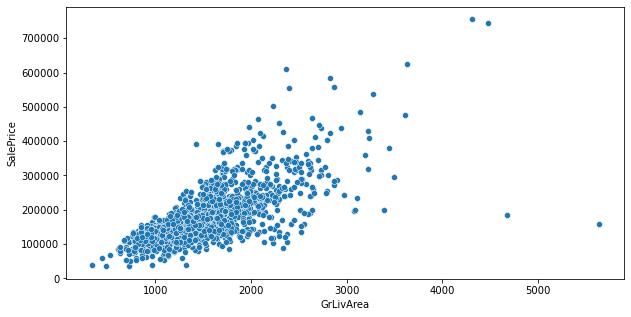

In [32]:
# Delete outliers from the training set

fig = plt.figure(figsize=(10,5)) ; 
sns.scatterplot(x='GrLivArea', y='SalePrice',data=train[['GrLivArea','SalePrice']])

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

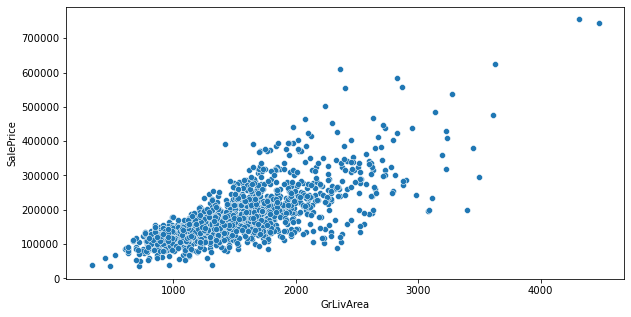

In [33]:
# Delete outliers (Large area, but too low SalePrice)
train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

fig = plt.figure(figsize=(10,5))
sns.scatterplot(x='GrLivArea', y='SalePrice', data = train[['GrLivArea', 'SalePrice']])

In [34]:
# Combine train and test set
total_df = pd.concat((train, test)).reset_index(drop=True)

In [35]:
# make a feature dafaframe
df_features = total_df.drop(['SalePrice'], axis=1)

In [36]:
# Let's check the features with high missing ratio
df_have_null.sort_values(by='nulls').tail(6)
# Delete the five features that have missing ratio more than 47%
df_features = df_features.drop(['FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC'],axis=1)
df_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,TSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


In [37]:
# fill the missing values with low missing ratio by using median() and mode()
# most of the features have missing ratio less than 6%
numeric = ['int64', 'float64']
for col in df_features.columns:
    if df_features[col].dtype in numeric:
        df_features[col] = df_features[col].fillna(df_features[col].median())
    else:
        df_features[col] = df_features[col].fillna(df_features[col].mode()[0])
df_features


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,TSsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,84,0,0,0,0,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,RM,21.0,1936,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,6,2006,WD,Normal
2913,160,RM,21.0,1894,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,24,0,0,0,0,0,4,2006,WD,Abnorml
2914,20,RL,160.0,20000,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,0,9,2006,WD,Abnorml
2915,85,RL,62.0,10441,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,32,0,0,0,0,700,7,2006,WD,Normal


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

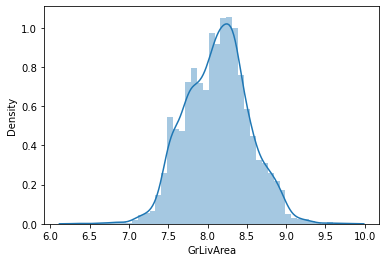

In [38]:
# Find high skewed features and perform transformation
# Transformation on features
numeric_features = []
for i in df_features.columns:
    if df_features[i].dtype in numeric:
        numeric_features.append(i)
        
skew_features = df_features[numeric_features].apply(lambda x : skew(x)).sort_values()
high_skew = skew_features[skew_features>0.5]
skew_index = high_skew.index

for i in skew_index:
    df_features[i] = boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))
 

#reciprocal doesn't work 
#1/df_features[i]    
#df_features[i]**(1/2)   
#np.log1p(df_features[i])
#boxcox1p(df_features[i], boxcox_normmax(df_features[i] + 1))

df_features[numeric_features].apply(lambda x : skew(x)).sort_values()

# example after transformation
sns.distplot(df_features['GrLivArea'])

In [ ]:
# If we use pd.get_dummies after simplifying the features, it won't change some features to dummies because they are numeric (like hasGarage = 1 or 0), but do they matter??? since it already acts like dummies? and they are 
# not redundant to GarageArea because GarageArea = 0 (meaning hasGarage = 0) removes hasGarage?

## Feature Engineering

In [39]:
df_features['TotalSF'] = df_features['TotalBsmtSF'] + df_features['1stFlrSF'] + df_features['2ndFlrSF']

df_features['TotalSF']

df_features['TotalNumBath'] = df_features['BsmtFullBath'] + 0.5*df_features['BsmtHalfBath'] + df_features['FullBath'] + 0.5*df_features['HalfBath'] 

# not exact because we also considered these as numeric variables and transformed them


0       1.068837
1       0.000000
2       1.068837
3       0.000000
4       1.068837
          ...   
2912    1.068837
2913    1.068837
2914    0.000000
2915    0.000000
2916    1.068837
Name: HalfBath, Length: 2917, dtype: float64

In [40]:
# Create dummy variables
df_features['has2ndFlr'] = df_features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
df_features['has2ndFlr']
df_features['hasBsmt'] = df_features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
len(df_features[df_features['hasBsmt'] == 0])
# There are 37 houses with no basements. 37 is pretty large, so keep the hasBsmt variable

df_features['hasgarage'] = df_features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

df_features['haspool'] = df_features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

df_features['hasfireplaces'] = df_features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df_features.shape

(2917, 81)

In [ ]:
# It makes sense to include has2ndFlr because SF = 3000 can be either bsmtSF = 1500, 1stSF = 1500 or 1000, 1000, 1000. 
# i.e TotalSF can be equal but having 2ndFlr or not might affect the SalePrice 

In [41]:
final_features = pd.get_dummies(df_features).reset_index(drop=True)
final_features.shape

(2917, 276)

In [42]:
# Let's check the final feature dataframe
final_features

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,6.499672,16.311602,13.833053,7,3.991517,2003,2003,19.433175,144.123182,0.0,...,0,0,0,1,0,0,0,0,1,0
1,4.249693,18.466368,14.117917,6,6.000033,1976,1976,0.000000,181.726299,0.0,...,0,0,0,1,0,0,0,0,1,0
2,6.499672,16.758972,14.476511,7,3.991517,2001,2002,17.768840,110.444830,0.0,...,0,0,0,1,0,0,0,0,1,0
3,6.862540,15.545033,14.106195,7,3.991517,1915,1970,0.000000,61.797104,0.0,...,0,0,0,1,1,0,0,0,0,0
4,6.499672,19.009679,15.022007,8,3.991517,2000,2000,25.404165,136.629574,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,9.030083,8.106494,10.765921,4,5.348041,1970,1970,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,1,0
2913,9.030083,8.106494,10.723222,4,3.991517,1970,1970,0.000000,69.032659,0.0,...,0,0,0,1,1,0,0,0,0,0
2914,4.249693,27.745335,15.820338,5,5.348041,1960,1996,0.000000,213.131986,0.0,...,0,0,0,1,1,0,0,0,0,0
2915,7.337374,15.854946,14.307158,5,3.991517,1992,1992,0.000000,85.019193,0.0,...,0,0,0,1,0,0,0,0,1,0


In [43]:
num_train = train.shape[0]
train = final_features[:num_train]
test = final_features[num_train:]
train.shape

(1458, 276)

In [44]:
# Perform log transformation
Y = total_df['SalePrice'][:num_train].reset_index(drop=True)
Y = np.log1p(Y)
Y

0       12.247699
1       12.109016
2       12.317171
3       11.849405
4       12.429220
          ...    
1453    12.072547
1454    12.254868
1455    12.493133
1456    11.864469
1457    11.901590
Name: SalePrice, Length: 1458, dtype: float64

In [45]:
# Create final X and Y for learning 
X = final_features.iloc[:len(Y),:]
print('X', X.shape, 'Y', Y.shape)

X (1458, 276) Y (1458,)


In [46]:
# rmse
kfolds = KFold(n_splits=10, shuffle = True, random_state=42)

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def rmse_cv(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, Y,scoring='neg_mean_squared_error', cv=kfolds))
    return rmse 


# neg_mean_squared_error: negated value of the distance between the model and the data
# cross_val_score: find score (0~1) using a given fitted model
# Don't need RidgeCV or other because cross_val_score does cross validation for you

In [47]:
# Create a list of possible hyperparameter for learning
alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [ ]:
###### Grid Search for optimal alphas (learning rate) ######
# alphas = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0])
# people choose popular values for alpha as a starting point for the search. Use the algorithm iteratively to narrow the value down

In [ ]:
# Difference between GridSearchCV and RandomizedSearchCV 
# GridSearchCV evaluates all possible values of hyperparameter -> if there are too many parameters, the running time is slow
# RandomizedSearchCV evaluates a random set of hyperparameters. useful when we have prior belief on what the hyperparameters should be
# ex) params = {
#   epoch = [20, 30, 40, 50], #those numbers are only for example
#   dense_layer_size = [20, 30], 
#   second_danse_layer = [30, 40]    }

#Grid Search tries all the combination 4*2*2 = 16 

## Build the architecture for base models

In [48]:
# Searching for best hyperparameter for Lasso
lasso =  Lasso()
lasso_search = GridSearchCV(estimator = lasso, param_grid = {'alpha': np.logspace(-4,-3,5)}, cv=5, scoring="neg_mean_squared_error")
lasso_search.fit(X, Y)
lasso_search.best_estimator_

# 0.001 is the best, so use np.logspace(-4,-2,5) , which is from 0.0001 to 0.01
# 0.0003162 is the best, so use np.logspace(-4,-3,5)
# 0.0005623 is the best, so use 0.0005

Lasso(alpha=0.0005623413251903491)

In [49]:
# Make pipeline for lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.0005))


In [ ]:
# randomizedSearchCV
#ridge = Ridge()
#rsearch = RandomizedSearchCV(estimator = ridge, param_distributions = {'alpha':sp_rand()}, n_iter = 100)
#rsearch.fit(X,Y)
#rsearch.best_estimator_.alpha

In [50]:
# Searching for best hyperparameter for Ridge

ridge = Ridge()
ridge_search = GridSearchCV(ridge, {'alpha': np.linspace(5, 10, 10)}, cv=5, scoring="neg_mean_squared_error")
ridge_search.fit(X,Y)
ridge_search.best_estimator_

# 8.33333 is found to be the best hyperparameter

Ridge(alpha=8.333333333333334)

In [51]:
# Make pipeline for Ridge
ridge = make_pipeline(RobustScaler(), Ridge(alpha=8.33333))


In [52]:
# Searching for best hyperpaameter for Elastic net
enet = ElasticNet()
enet_search = GridSearchCV(enet, {'alpha': np.linspace(0.0001, 0.001, 10), 'l1_ratio':np.linspace(0.5, 1.5, 10)}, cv=5, scoring="neg_mean_squared_error")
enet_search.fit(X,Y)
enet_search.best_estimator_

# alpha = 0.0003 and l1_ratio = 1.5 are found to be the best hyperparameter


ElasticNet(alpha=0.0003, l1_ratio=1.5)

In [53]:
# Make pipeline for elastic net
enet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0003, l1_ratio=1.5))

In [54]:
svr = make_pipeline(RobustScaler(), SVR(C = 20, epsilon = 0.008, gamma=0.0003))

In [55]:
gbr = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05, max_depth=4,
                                max_features='sqrt', min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=42)

In [56]:
lightgbm = LGBMRegressor(objective='regression',num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )

In [57]:
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)


In [ ]:
###### From GridSearchCV, 10 is the best estimator for Ridge. Changing it to 10 decreased the error

#ridge = make_pipeline(RidgeCV(alphas=(0,1,2), cv=kfolds))
#lasso1 = make_pipeline(StandardScaler(), LassoCV(alphas=alphas2, random_state=42, cv=kfolds))
#elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e7, alphas=e_alphas, cv=kfolds, l1_ratio=e_l1ratio))
#svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003,))

## Base Model Scores

In [61]:
# Ridge
score = rmse_cv(ridge)
print('Mean RMSE score for ridge is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

mean RMSE score for ridge is 0.1074 with standard deviation of 0.0162


In [62]:
# Lasso

score = rmse_cv(lasso)
print('Mean RMSE score for Lasso is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

Mean RMSE score for Lasso is 0.1060 with standard deviation of 0.0162


In [63]:
# SVR

score = rmse_cv(svr)
print('Mean RMSE score for SVR is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

Mean RMSE score for SVR is 0.1072 with standard deviation of 0.0165


In [64]:
# Elastic Net

score = rmse_cv(enet)
print('Mean RMSE score for Elastic Net is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

Mean RMSE score for Elastic Net is 0.1060 with standard deviation of 0.0162


In [65]:
# Gradient Boosting Regressor

score = rmse_cv(gbr)
print('Mean RMSE score for GBR is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

Mean RMSE score for GBR is 0.1151 with standard deviation of 0.0150


In [66]:
# LightGBM

score = rmse_cv(lightgbm)
print('Mean RMSE score for LightGBM is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_f

In [67]:
# XGBoost

score = rmse_cv(xgboost)
print('Mean RMSE score for XGBoost is %.4f with standard deviation of %.4f' %(score.mean(), score.std()))

[23:10:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:10:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:10:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:11:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:11:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:11:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:17

## Model Stacking

In [68]:
# Stack the model using xgboost as a meta regressor
stacked_model = StackingCVRegressor(regressors=(ridge, lasso, gbr, xgboost, lightgbm, svr),
                                    meta_regressor=xgboost, use_features_in_secondary=True)

## Model fit using train X and train Y 

In [69]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stacked_model.fit(np.array(X), np.array(Y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = enet.fit(X, Y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, Y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, Y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, Y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, Y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, Y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, Y)

START Fit
2021-08-20 23:13:35.477479 StackingCVRegressor
[23:14:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:14:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:15:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:15:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[23:15:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsampl

In [ ]:
# The importance (weights) of each model can be decided by changing the weight and trying over and over again. 
# Equally divide the weight first, give more weight for the model with a better score (rmse in current Regression problem) and less weight for the model with a worse score

# 1) stacked_model set to be 0.3 b/c it is a stack model of all.
# 2) xgboost set to be 0.15 b/c it is a meta model which usually has the best result.
# 3) All the weights are decided by the next step rmse(y, blend_models_predict(X)). Get the smallest rmse is the total purpose.

In [70]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + 
            (0.05 * lasso_model_full_data.predict(X)) + 
            (0.1 * ridge_model_full_data.predict(X)) + 
            (0.1 * svr_model_full_data.predict(X)) + 
            (0.1 * gbr_model_full_data.predict(X)) + 
            (0.15 * xgb_model_full_data.predict(X)) + 
            (0.1 * lgb_model_full_data.predict(X)) + 
            (0.3 * stack_gen_model.predict(np.array(X))))

In [71]:
print('RMSE score on train data:')
print(rmse(Y, blend_models_predict(X)))
# Blending the models significantly increase the accuracy

RMSE score on train data:
0.061190398340384186


In [ ]:
# need to perform inverse log transformation(exponentiate) on the predicted Y.
predicted_SalePrice = np.expm1(blend_models_predict(test))

## Create submission file

In [ ]:
sub = pd.DataFrame()
sub['id'] = test_ID
sub['SalePrice'] = predicted_SalePrice
sub.to_csv('submission.csv', index=False)